In [2]:
import pandas as pd
import os


def get_csv_data(video_folder_name, fileName):
    data = pd.read_csv(fileName, sep=';')
    data.columns = ['ID', 'file_name', 'cut_frame']
    file_paths = []
    for entry in data.iloc():
        file_paths.append(video_folder_name + entry['file_name'])
    data['file_path'] = file_paths
    return data


training = get_csv_data(
    '../WS2020_DeepLearning_Videos/Task2_Training_Validation/', '../Task2_Training.csv')
test = get_csv_data(
    '../WS2020_DeepLearning_Videos/Task2_Test/', '../Task2_Test.csv')

training.dropna(inplace=True)
test.dropna(inplace=True)

display(training)
display(test)

,ID,file_name,cut_frame,file_path
0,1,_8Vy3dlHg2w_00132.mp4,63.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
1,2,_8Vy3dlHg2w_00133.mp4,25.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
2,3,_8Vy3dlHg2w_00136.mp4,71.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
3,4,_8Vy3dlHg2w_00139.mp4,35.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
4,5,_8Vy3dlHg2w_00142.mp4,20.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
...,...,...,...,...
295,296,_tigfCJFLZg_00285.mp4,51.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
296,297,_tigfCJFLZg_00286.mp4,130.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
297,298,_tigfCJFLZg_00289.mp4,52.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
298,299,_tigfCJFLZg_00290.mp4,122.0,../WS2020_DeepLearning_Videos/Task2_Training_V...


,ID,file_name,cut_frame,file_path
0,1,_tigfCJFLZg_00293.mp4,131.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
1,2,_tigfCJFLZg_00295.mp4,85.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
2,3,_tigfCJFLZg_00298.mp4,93.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
3,4,_tigfCJFLZg_00299.mp4,138.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
4,5,_tigfCJFLZg_00301.mp4,124.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
...,...,...,...,...
85,86,_tigfCJFLZg_00428.mp4,45.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
86,87,_tigfCJFLZg_00429.mp4,125.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
87,88,_tigfCJFLZg_00430.mp4,49.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
90,91,_tigfCJFLZg_00435.mp4,44.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...


## Build data

### Build process

In [3]:
from data_fns import drop_problematic_videos, get_frames_labels, build_data
from model_fns import build_model, train_model, evaluate_model

def run(training, test, augmentations, size, use_standardization, drop_problematic):
    print(f"""Beginning process with parameters: 
    augmentations = {augmentations},
    size = {size},
    standardization = {use_standardization},
    drop_problematic = {drop_problematic}""")
    
    clean_training = training
    clean_test = test
    if drop_problematic:
        clean_training, clean_test = drop_problematic_videos(training, test)
    training_frames, training_labels, augmented_training_frames, augmented_training_labels = get_frames_labels(
        clean_training, augmentations, size, use_standardization)
    test_frames, test_labels, augmented_test_frames, augmented_test_labels = get_frames_labels(
        clean_test, augmentations=[], size=size, use_standardization=False)
    data = build_data(
        training={
            "frames": training_frames,
            "labels": training_labels,
            "augmented_frames": augmented_training_frames,
            "augmented_labels": augmented_training_labels
        },
        test={
            "frames": test_frames,
            "labels": test_labels,
            "augmented_frames": augmented_test_frames,
            "augmented_labels": augmented_test_labels
        },
        validation_split=0.33
    )
    x_train = data["training"]["x"]
    y_train = data["training"]["y"]
    x_validation = data["training"]["x_validation"]
    y_validation = data["training"]["y_validation"]
    all_test_frames = data["test"]["x"]
    all_test_labels = data["test"]["y"]
    size1, size2 = size
    model = build_model(input_shape = (size1, size2, 3))
    model.summary()
    history = train_model(model, x_train, y_train, x_validation, y_validation)

    accuracy = evaluate_model(history, model, all_test_frames, all_test_labels)
    return accuracy

### General build properties

Beginning process with parameters: 
    augmentations = [],
    size = (32, 32),
    standardization = True,
    drop_problematic = True
(299, 4)
(87, 4)
Basic Training frames: 10480
Augmented Training frames: 0
Training frames: 10480
Basic Test frames: 9683
Augmented Test frames: 0
Test frames: 9683
Final training frames: 7021
Final validation frames: 3459
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
__________________________

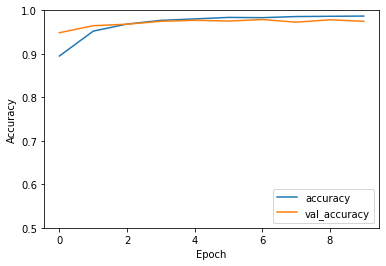

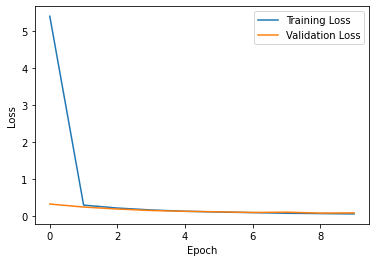

303/303 - 1s - loss: 0.1502 - accuracy: 0.9436
Test Accuracy: 0.9436125159263611, Test Loss: 0.15020997822284698


0.9436125159263611

In [4]:
# Build properties #
# You can use those properties to control the build proces #
# ---------------------------------------------------------#

class_names = ['wet', 'dry']

augmentations = []
size = (64,64)
use_standardization = True
drop_problematic = False

run(training, test, augmentations=[], size=(32,32), use_standardization=True, drop_problematic=True)
# run(training, test, augmentations=['flip'], size=(64,64), use_standardization=True, drop_problematic=True)

In [7]:
import pickle

with open("best_dataset.pkl", "wb") as output_file:
    pickle.dump(data, output_file)

In [8]:
with open("best_dataset.pkl", "rb") as output_file:
    data = pickle.load(output_file)
print(data)

{'training': {'x': array([[[[ 93,  94,  97],
         [ 95,  94,  99],
         [ 94,  92,  95],
         ...,
         [ 75,  68,  66],
         [ 74,  67,  65],
         [ 62,  55,  53]],

        [[ 95,  94,  97],
         [ 96,  93,  97],
         [ 97,  95,  96],
         ...,
         [ 77,  70,  68],
         [ 77,  70,  68],
         [ 57,  50,  48]],

        [[ 94,  94,  94],
         [ 98,  96,  97],
         [101, 100, 103],
         ...,
         [ 77,  70,  68],
         [ 76,  69,  67],
         [ 57,  50,  48]],

        ...,

        [[ 91, 143, 197],
         [ 86, 138, 205],
         [ 76, 133, 198],
         ...,
         [ 45, 117, 195],
         [ 46, 115, 192],
         [ 44, 113, 190]],

        [[ 87, 135, 187],
         [ 80, 135, 201],
         [ 72, 132, 198],
         ...,
         [ 46, 119, 197],
         [ 41, 117, 194],
         [ 40, 116, 193]],

        [[119, 171, 197],
         [118, 178, 198],
         [124, 185, 199],
         ...,
         [ 44, 

### Display example pictures

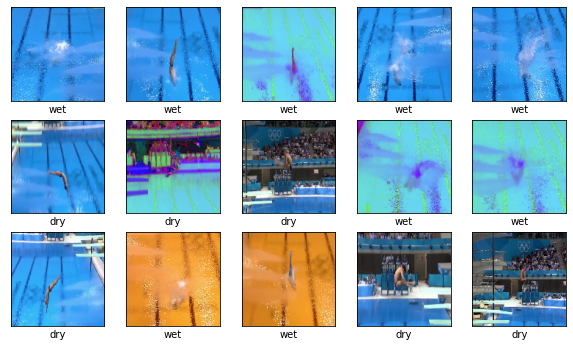

In [242]:
from img_fns import show_images

first_image = 50
last_image = 65
images = x_train
labels = y_train

show_images(first_image, last_image, images, labels, class_names)